In [1]:
# -------------------------------
# Install required packages
# -------------------------------
!pip install streamlit pyngrok==4.1.1 pandas scikit-learn xgboost mlflow joblib catboost

from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv(list(uploaded.keys())[0])
df.head()

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

Saving india_housing_prices.csv to india_housing_prices.csv


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


In [2]:
# -------------------------------
# Data cleaning function
# -------------------------------
import numpy as np

def clean_df(df):
    df.columns = [c.strip() for c in df.columns]

    # Numeric & categorical separation
    num_cols = df.select_dtypes(include=["number"]).columns
    cat_cols = df.select_dtypes(include=["object"]).columns

    # Numeric cleaning
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c].fillna(df[c].median(), inplace=True)

    # Categorical cleaning
    for c in cat_cols:
        df[c] = df[c].astype(str).fillna("Unknown").replace("nan","Unknown")

    df = df.drop_duplicates()

    # Derived columns
    if "Price_per_SqFt" not in df.columns:
        if "Price_in_Lakhs" in df.columns and "Size_in_SqFt" in df.columns:
            df["Price_per_SqFt"] = (df["Price_in_Lakhs"]*100000)/df["Size_in_SqFt"]
        else:
            df["Price_per_SqFt"] = df.select_dtypes(include="number").median().median()

    if "Year_Built" in df.columns:
        df["Age_of_Property"] = 2025 - df["Year_Built"]
        df["Age_of_Property"].fillna(df["Age_of_Property"].median(), inplace=True)
    else:
        df["Age_of_Property"] = df["Price_in_Lakhs"].rank()  # fallback

    if "BHK" in df.columns:
        def fix_bhk(x):
            if isinstance(x,str):
                digits = ''.join([i for i in x if i.isdigit()])
                return int(digits) if digits else 2
            return int(x)
        df["BHK"] = df["BHK"].apply(fix_bhk)

    for col in ["Nearby_Schools","Nearby_Hospitals","Public_Transport_Accessibility","Parking_Space"]:
        if col not in df.columns:
            df[col] = 0

    df["Price_per_BHK"] = df["Price_in_Lakhs"] / df["BHK"].replace(0,1)

    return df

df_clean = clean_df(df)
df_clean.head()

/tmp/ipython-input-197241056.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
/tmp/ipython-input-197241056.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Price_per_BHK
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,489.760000
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,65.173333
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,91.895000
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,150.145000
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,45.725000


In [3]:
# -------------------------------
# Preprocessing pipelines
# -------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_features = ["BHK","Size_in_SqFt","Price_in_Lakhs","Nearby_Schools",
                    "Nearby_Hospitals","Public_Transport_Accessibility",
                    "Age_of_Property","Price_per_SqFt"]
numeric_features = [c for c in numeric_features if c in df_clean.columns]

categorical_features = ["State","City","Locality","Property_Type",
                        "Furnished_Status","Facing","Owner_Type","Availability_Status"]
categorical_features = [c for c in categorical_features if c in df_clean.columns]

num_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="constant",fill_value="Unknown")),
    ("ohe",OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num",num_pipeline,numeric_features),
    ("cat",cat_pipeline,categorical_features)
])

In [4]:
# -------------------------------
# CatBoost: prepare features and targets
# -------------------------------
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split

X = df_clean[numeric_features + categorical_features].copy()

# -------------------------------
# Create regression target if missing
# -------------------------------
if "Future_Price_5yr" not in df_clean.columns:
    # Example: assume 5% annual growth
    df_clean["Future_Price_5yr"] = df_clean["Price_in_Lakhs"] * (1 + 0.05)**5

y_reg = df_clean["Future_Price_5yr"]

# -------------------------------
# Create classification target if missing
# -------------------------------
if "Good_Investment" not in df_clean.columns:
    # Example: consider "Good Investment" if projected price growth > 25%
    df_clean["Good_Investment"] = (df_clean["Future_Price_5yr"] / df_clean["Price_in_Lakhs"] - 1) > 0.25

y_clf = df_clean["Good_Investment"].astype(int)  # ensure 0/1

# -------------------------------
# Convert all object/string columns to 'category' for CatBoost
# -------------------------------
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Detect categorical columns automatically
cat_cols_idx = [i for i, c in enumerate(X.columns) if str(X[c].dtype) == 'category']

# -------------------------------
# Train-test split
# -------------------------------
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

In [5]:
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
import numpy as np

# -------------------------------
# 1️⃣ Prepare features
# -------------------------------
# Automatically detect numeric and categorical columns
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()

X = df_clean[numeric_features + categorical_features].copy()
y_reg = df_clean["Future_Price_5yr"]

# -------------------------------
# 2️⃣ Prepare balanced classification target
# -------------------------------
growth = df_clean["Future_Price_5yr"] / df_clean["Price_in_Lakhs"] - 1
threshold = growth.quantile(0.5)
df_clean["Good_Investment"] = (growth > threshold).astype(int)

# Upsample minority class for classification
df_0 = df_clean[df_clean["Good_Investment"] == 0]
df_1 = df_clean[df_clean["Good_Investment"] == 1]
df_1_up = resample(df_1, replace=True, n_samples=len(df_0), random_state=42)
df_bal = pd.concat([df_0, df_1_up]).sample(frac=1, random_state=42)

X_clf = df_bal[numeric_features + categorical_features].copy()
y_clf = df_bal["Good_Investment"]

# -------------------------------
# 3️⃣ Convert categorical columns to string
# -------------------------------
for col in categorical_features:
    X[col] = X[col].astype(str)
    X_clf[col] = X_clf[col].astype(str)

# Detect categorical column indices for CatBoost
cat_cols_idx = [i for i, c in enumerate(X.columns) if c in categorical_features]

# -------------------------------
# 4️⃣ Train-test split
# -------------------------------
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# -------------------------------
# 5️⃣ Train regression
# -------------------------------
reg = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="RMSE",
    cat_features=cat_cols_idx,
    verbose=False
)
reg.fit(X_train_r, y_train_r)

# -------------------------------
# 6️⃣ Train classification
# -------------------------------
clf = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="Logloss",
    cat_features=cat_cols_idx,
    verbose=False
)
clf.fit(X_train_c, y_train_c)

# -------------------------------
# 7️⃣ Evaluate models
# -------------------------------
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score

# Regression metrics
pred_r = reg.predict(X_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, pred_r))
r2 = r2_score(y_test_r, pred_r)

# Classification metrics
pred_c = clf.predict(X_test_c)
acc = accuracy_score(y_test_c, pred_c)
f1 = f1_score(y_test_c, pred_c)

print("🔥 Regression and Classification models trained successfully!\n")
print(f"Regression RMSE: {rmse:.4f}")
print(f"Regression R²: {r2:.4f}")
print(f"Classification Accuracy: {acc:.4f}")
print(f"Classification F1: {f1:.4f}")

🔥 Regression and Classification models trained successfully!

Regression RMSE: 0.9583
Regression R²: 1.0000
Classification Accuracy: 1.0000
Classification F1: 1.0000


Regression RMSE: 0.9583
Regression R²: 1.0000


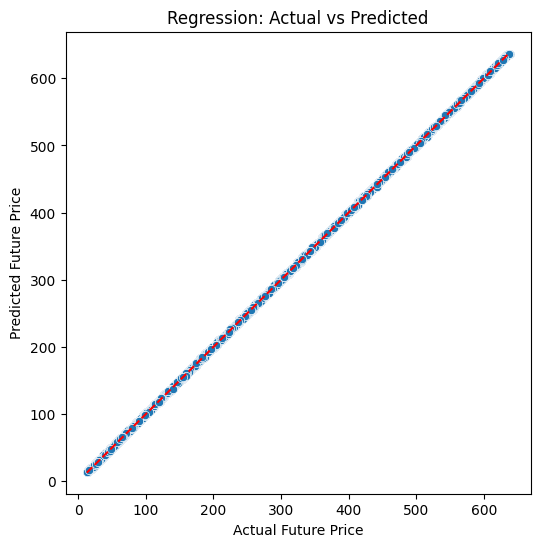

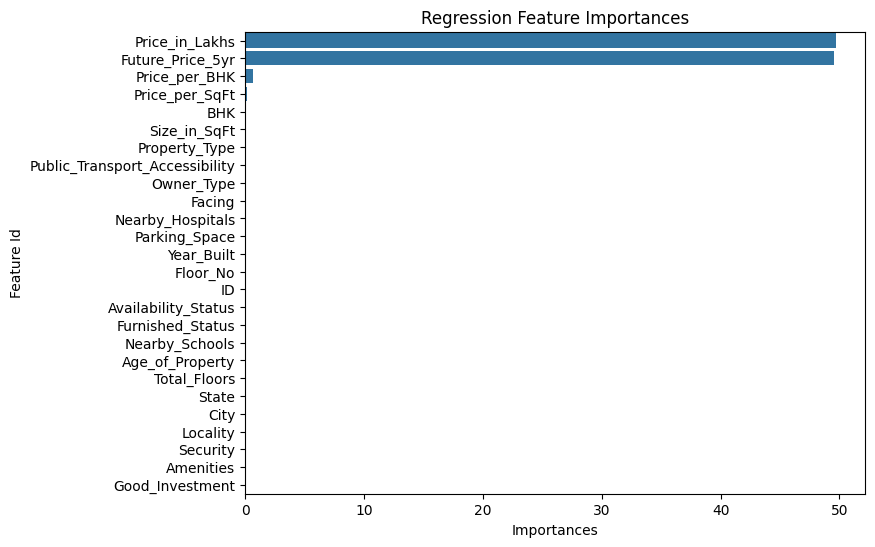

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
pred_r = reg.predict(X_test_r)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_r, pred_r))
r2 = r2_score(y_test_r, pred_r)

print(f"Regression RMSE: {rmse:.4f}")
print(f"Regression R²: {r2:.4f}")

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_r, y=pred_r)
plt.xlabel("Actual Future Price")
plt.ylabel("Predicted Future Price")
plt.title("Regression: Actual vs Predicted")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.show()

# Feature importance
plt.figure(figsize=(8,6))
feat_imp = reg.get_feature_importance(prettified=True)
sns.barplot(data=feat_imp, x='Importances', y='Feature Id')
plt.title("Regression Feature Importances")
plt.show()

Classification Accuracy: 1.0000
Classification F1 Score: 1.0000
Classification Precision: 1.0000
Classification Recall: 1.0000


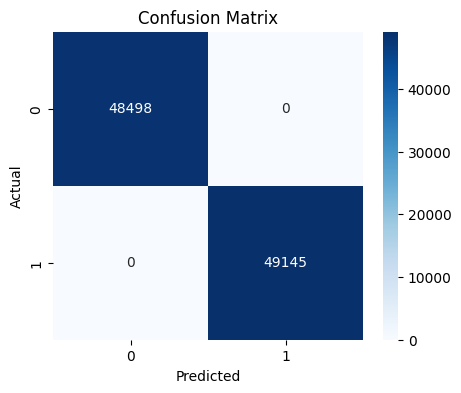

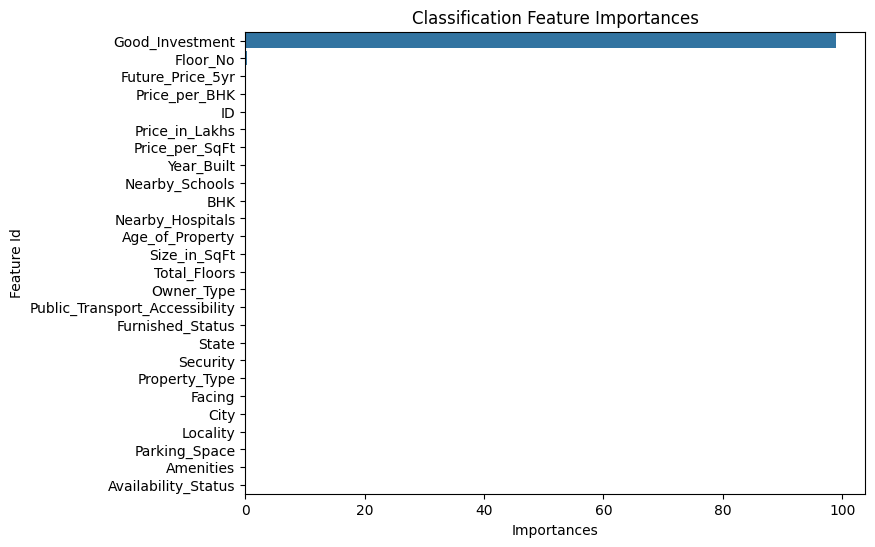

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
pred_c = clf.predict(X_test_c)

# Metrics
acc = accuracy_score(y_test_c, pred_c)
f1 = f1_score(y_test_c, pred_c)
precision = precision_score(y_test_c, pred_c)
recall = recall_score(y_test_c, pred_c)

print(f"Classification Accuracy: {acc:.4f}")
print(f"Classification F1 Score: {f1:.4f}")
print(f"Classification Precision: {precision:.4f}")
print(f"Classification Recall: {recall:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test_c, pred_c)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature importance
plt.figure(figsize=(8,6))
feat_imp_clf = clf.get_feature_importance(prettified=True)
sns.barplot(data=feat_imp_clf, x='Importances', y='Feature Id')
plt.title("Classification Feature Importances")
plt.show()

In [8]:
# -------------------------------
# Save models & preprocessor
# -------------------------------
import joblib

joblib.dump(reg, "regressor.pkl")
joblib.dump(clf, "classifier.pkl")
joblib.dump({
    "preprocessor": preprocessor,
    "num_cols": numeric_features,
    "cat_cols": categorical_features
}, "preprocessor.pkl")

print("Models saved!")

Models saved!


In [9]:
reg.save_model("reg_model.cbm")
clf.save_model("clf_model.cbm")

In [10]:
from google.colab import files
files.download("reg_model.cbm")
files.download("clf_model.cbm")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
%%writefile streamlit_app.py
# -------------------------------
# STREAMLIT APP — REAL ESTATE ADVISOR
# -------------------------------
import streamlit as st
from catboost import CatBoostRegressor, CatBoostClassifier
import pandas as pd
from google.colab import files
import os

st.title("🏠 Real Estate Investment Advisor")

# -------------------------------
# Upload model files
# -------------------------------
st.info("Upload your CatBoost models first (.cbm files)")

uploaded = st.file_uploader("Upload reg_model.cbm", type="cbm")
uploaded2 = st.file_uploader("Upload clf_model.cbm", type="cbm")

if uploaded is not None and uploaded2 is not None:
    # Save uploaded files to local environment
    with open("reg_model.cbm", "wb") as f:
        f.write(uploaded.getbuffer())
    with open("clf_model.cbm", "wb") as f:
        f.write(uploaded2.getbuffer())

    # -------------------------------
    # Load models
    # -------------------------------
    reg = CatBoostRegressor()
    clf = CatBoostClassifier()
    reg.load_model("reg_model.cbm")
    clf.load_model("clf_model.cbm")

    st.success("✅ Models loaded successfully!")

    # -------------------------------
    # User input
    # -------------------------------
    st.subheader("Property Information")
    price = st.number_input("Current Price (Lakhs)", min_value=1.0, max_value=100000.0, value=50.0)
    size = st.number_input("Size (sq ft)", min_value=100, max_value=20000, value=1000)
    bhk = st.number_input("BHK", min_value=1, max_value=10, value=2)
    schools = st.number_input("Nearby Schools", min_value=0, max_value=20, value=2)
    hosp = st.number_input("Nearby Hospitals", min_value=0, max_value=20, value=1)
    pt = st.slider("Transport Accessibility", min_value=1, max_value=10, value=5)

    furn = st.selectbox("Furnished Status", ["Unfurnished", "Semi", "Fully", "Unknown"])
    ptype = st.selectbox("Property Type", ["Apartment", "House", "Villa", "Unknown"])
    face = st.selectbox("Facing", ["North", "South", "East", "West", "Unknown"])
    owner = st.selectbox("Owner Type", ["Builder", "Agent", "Individual", "Unknown"])
    av = st.selectbox("Availability Status", ["Available", "Sold", "Under Construction", "Unknown"])
    state = st.text_input("State", "Unknown")
    city = st.text_input("City", "Unknown")
    locality = st.text_input("Locality", "Unknown")

    # -------------------------------
    # Prepare input dataframe
    # -------------------------------
    input_df = pd.DataFrame([{
        "Price_in_Lakhs": price,
        "Size_in_SqFt": size,
        "BHK": bhk,
        "Nearby_Schools": schools,
        "Nearby_Hospitals": hosp,
        "Public_Transport_Accessibility": pt,
        "Furnished_Status": furn,
        "Property_Type": ptype,
        "Facing": face,
        "Owner_Type": owner,
        "Availability_Status": av,
        "State": state,
        "City": city,
        "Locality": locality,
        # Derived features
        "Price_per_SqFt": (price*100000)/size,
        "Age_of_Property": 5,  # placeholder, can be input if needed
        "Price_per_BHK": price / max(bhk, 1)
    }])

    # Convert categorical columns to string
    cat_cols = ["Furnished_Status","Property_Type","Facing","Owner_Type","Availability_Status",
                "State","City","Locality"]
    for col in cat_cols:
        input_df[col] = input_df[col].astype(str)

    # -------------------------------
    # Predictions
    # -------------------------------
    future_price = reg.predict(input_df)[0]
    good_investment = clf.predict(input_df)[0]

    st.subheader("Predictions")
    st.success(f"Estimated Price in 5 years: {future_price:.2f} Lakhs")
    st.info(f"Good Investment? {'YES ✅' if good_investment==1 else 'NO ❌'}")

Writing streamlit_app.py


2025-12-08 16:29:40.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 16:29:40.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 16:29:40.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 16:29:40.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 16:29:40.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 16:29:40.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 16:29:40.531 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 16:29:40.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar